### The idea

The term fake news gained prominence during the last US election, but have been around for a while. The problem is that now they have saturated the media landscape with ever more scandalous titles, and have reached a point where it is difficult to tell the fake from real. They are widely used for political purposes and supposedly shaped the last US elections and are part of the widespread russian hybrid war. 

The goal of this "excercise" is to explore these fake news: Where do they come from? What is in them? What topics get the most involvement? Finally I will try to build a classifier that tries to tell fake from clickbait from real news, and a fake news generator, that will hopefully capture the essence.


### Plan of attack 

1. Which media have the most fake news in the dataset?
    Looks like the way the dataset is constructed you get at most 100 titles from a media. So not the best metric        
2. What are the most common words and bigrams you find in titles? +
3. What are the most common words and bigrams you find in texts? +
4. What topics get the most interest (likes, shares and comments)?
5. Which medias get the most interest (likes, shares and comments)? +
6. Can we build fake news classifier:
    - Need to get non-fake-news data.
    - Would it work by title only?
    - Classify fake news, clickbait, real_news
    - T-SNE, clustering and other visualisation. 
    - Word distributions in different groups
    - Deep vs traditional
    - word2vec vs. tf-idf
7. How often do capital letters appear in titles? Can we use these as a predictor?
8. What do the texts of the articles tell us - can we find common patterns, topics, etc.? +
9. Can we build a fake news generator?
    - GAN? Nope.
    - RNN or something?
10. Obtain more news to see if the set reflects current state of fake news media. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
# TODO - Stemming

In [2]:
n_samples = 2000
n_features = 1000
n_components = 5
n_top_words = 10

stopwords = list(set(stopwords.words('english')))
generic_stopwords = ['-', '&', '|', 'http','https', 'share', 
                  'tags', 'html','com', 'www', 'infowars', 'infowarsstore',
                    'brain force']
sns.set()

In [3]:
def make_wordcloud(texts, stopwords, title="Wordcloud", plot=True):
    """
    Helper function that will plot a word cloud from a text or list of texts
    """
    if type(texts) is list:
        texts = ' '.join(texts)
    texts = texts.lower()
    wordcloud = WordCloud(max_font_size=70,
                          background_color="white",
                          max_words=2000,
                          collocations=True,
                          width=400,
                          height=400,
    
                          stopwords=stopwords).generate(texts)
    if not plot:
        return wordcloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    

def print_top_words(model, feature_names, n_top_words):
    
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_topics(texts):
    
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words=stopwords)
    tfidf = tfidf_vectorizer.fit_transform(texts)
    nmf = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)

In [4]:

# Prepare and clean data
data = pd.read_csv("fake.csv", header=0)
print(set(data.language))
print(set(data.type))
# We want only english on this one. Unfortunately reduces the dataset down to a third of its original size
data = data[data.language == 'english'] 
data = data.dropna()

{'russian', 'chinese', 'arabic', 'dutch', 'italian', 'portuguese', 'norwegian', 'german', 'turkish', 'english', 'polish', 'ignore', 'greek', 'spanish', 'finnish', 'french'}
{'hate', 'conspiracy', 'bias', 'bs', 'state', 'satire', 'fake', 'junksci'}


In [5]:
data.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [6]:
satire = data[data.type=='satire']
consp = data[data.type=='conspiracy']
consp = consp[~consp.text.str.contains("Brain Force")]
state = data[data.type=='state']
bs = data[data.type=='bs']
bias = data[data.type=='bias']
fake = data[data.type=='fake']
junksci = data[data.type=='junksci']
hate = data[data.type=='hate']
data = data[~data.text.str.contains("Brain Force")]

In [7]:
infowars = data[data.site_url=='infowars.com']
print(infowars.shape)
for i in range(infowars.shape[0]):
    #print(list(infowars.title)[i])
    if "tzrwu" in list(infowars.text)[i]:
        print(list(infowars.title)[i])
        print(list(infowars.text)[i])
        print("-------")
# 81 out of 200 contan legit titles but the text is just an advertisement

for i in range(infowars.shape[0]):
    #print(list(infowars.title)[i])
    if "Brain Force" in list(infowars.text)[i]:
        print(list(infowars.title)[i])
        print(list(infowars.text)[i])
        print("-------")
# 81 out of 200 contan legit titles but the text is just an advertisement

(81, 20)


### Dataset type composition

By far the most news are the ones labelled as 'bs'. Seems that this category is a throw it all that features a lot of data that would otherwise be in another category. Biased news, conspiracy theories, hate news and junkscience follow. Now the question here is how much does this distributon capture what is actually out there and is there a way to get an idea for that? I will try to come back to that later.

[('hate', 99), ('conspiracy', 144), ('bias', 271), ('bs', 3737), ('state', 6), ('fake', 2), ('junksci', 97)]


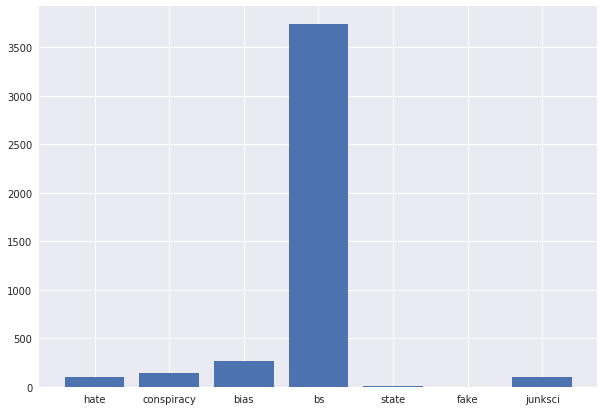

In [8]:
types = set(data.type)
sizes = []
for t in types:
    sizes.append((t, data[data.type==t].shape[0]))
print(sizes)

plt.figure(figsize=[10,7])
plt.bar(left = [x for x in range(len(types))], height = [x[1] for x in sizes])
plt.xticks([x for x in range(len(types))], [x[0] for x in sizes])
plt.show()

### Wordclouds

Lets have a look at the wordclouds of the texts of the news in the major categories. 
Initially all clouds had the names of the presidential candidates as well as former president Obama feature prominently.
So, I added them to the stopwords, to see what else is there. 

At a first glance most wordclouds feature some of the same prominent words, yet have their own slant. The junk
science news seem to stand on its own, as it features a lot more health related words. Most other 'fake news'
seem to be overly political. 

It seems there is quite the little marketing campaign going on in conspiracy. Might also be the case that most of those news come exclusively from infowars. 

Next step would be comparing word distributions and trying to do PCAs, clustering, etc. 



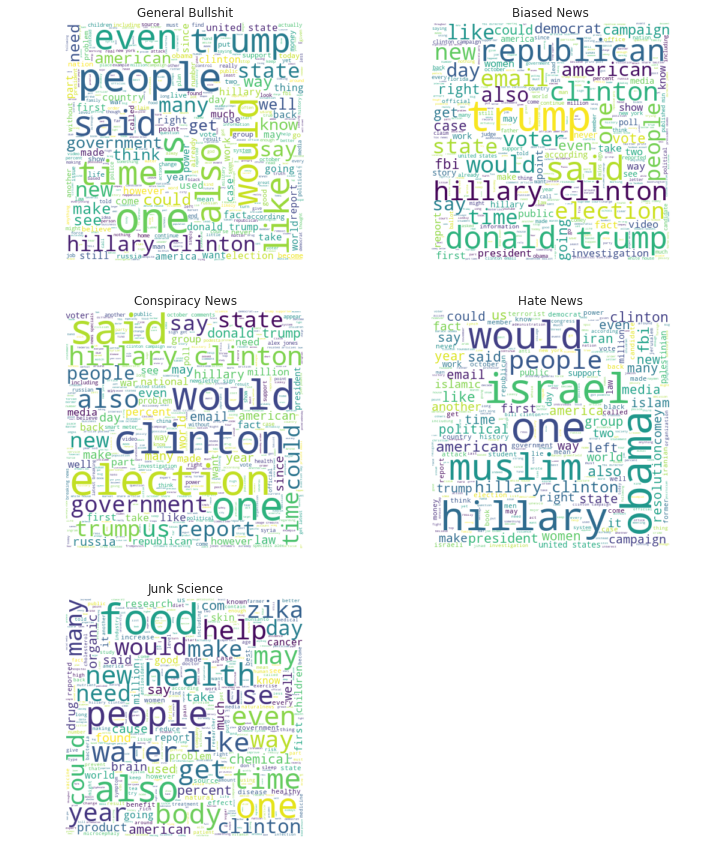

In [9]:
n_cols = 2
n_rows = 3

f, axes = plt.subplots(n_rows, n_cols, figsize=[12,15], sharex='all', sharey='all')
#print(axes)

axes[0, 0].imshow(make_wordcloud(list(bs.text), stopwords, "General Bullshit", plot=False), interpolation="bilinear")
axes[0, 0].set_title("General Bullshit")
axes[0, 0].axis("off")
axes[0 ,1].imshow(make_wordcloud(list(bias.text), stopwords, "Biased News", plot=False), interpolation="bilinear")
axes[0, 1].set_title("Biased News")
axes[0, 1].axis("off")
axes[1, 0].imshow(make_wordcloud(list(consp.text), stopwords, "Conspiracy news", plot=False), interpolation="bilinear")
axes[1, 0].set_title("Conspiracy News")
axes[1, 0].axis("off")
axes[1, 1].imshow(make_wordcloud(list(hate.text), stopwords, "Hate news", plot=False), interpolation="bilinear")
axes[1, 1].set_title("Hate News")
axes[1, 1].axis("off")

axes[2, 0].imshow(make_wordcloud(list(junksci.text), stopwords, "Fake Science news", plot=False), interpolation="bilinear")
axes[2, 0].set_title("Junk Science")
axes[2, 0].axis("off")
axes[2, 1].axis("off")
plt.show()



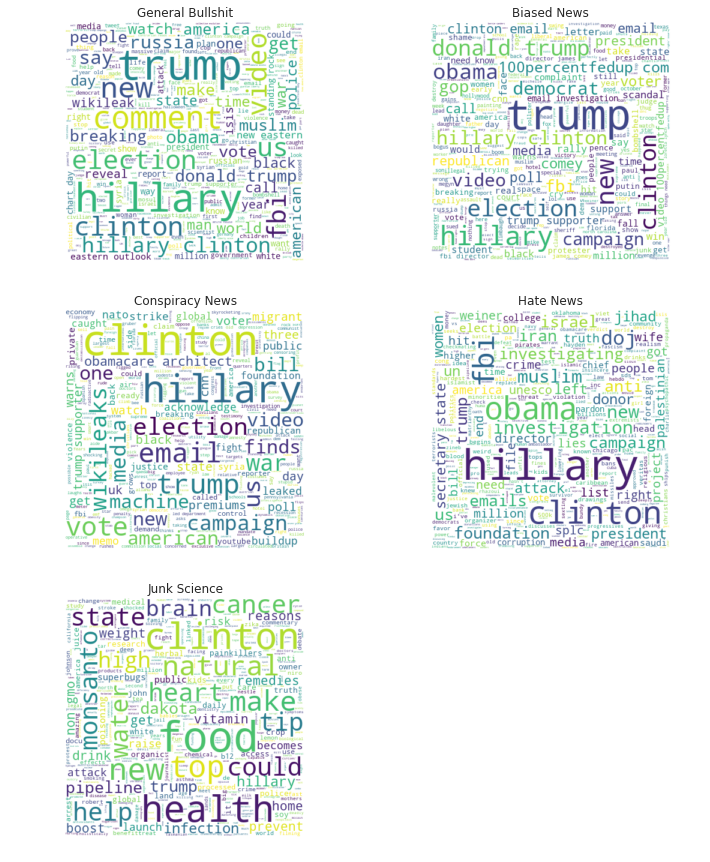

In [10]:
n_cols = 2
n_rows = 3

f, axes = plt.subplots(n_rows, n_cols, figsize=[12,15], sharex='all', sharey='all')
#print(axes)

axes[0, 0].imshow(make_wordcloud(list(bs.title), stopwords, "General Bullshit", plot=False), interpolation="bilinear")
axes[0, 0].set_title("General Bullshit")
axes[0, 0].axis("off")
axes[0 ,1].imshow(make_wordcloud(list(bias.title), stopwords, "Biased News", plot=False), interpolation="bilinear")
axes[0, 1].set_title("Biased News")
axes[0, 1].axis("off")
axes[1, 0].imshow(make_wordcloud(list(consp.title), stopwords, "Conspiracy news", plot=False), interpolation="bilinear")
axes[1, 0].set_title("Conspiracy News")
axes[1, 0].axis("off")
axes[1, 1].imshow(make_wordcloud(list(hate.title), stopwords, "Hate news", plot=False), interpolation="bilinear")
axes[1, 1].set_title("Hate News")
axes[1, 1].axis("off")

axes[2, 0].imshow(make_wordcloud(list(junksci.title), stopwords, "Fake Science news", plot=False), interpolation="bilinear")
axes[2, 0].set_title("Junk Science")
axes[2, 0].axis("off")
axes[2, 1].axis("off")
plt.show()


In this dataset only a few websites have any number of likes shares and comments. On top of that it is strange 
that the likes and shares are always the same number. In any case the site with the most shares is naturalnews. This is interesting since the category of junk science in the dataset is fairly small. 
- TODO: Look into it
- TODO: Check how much of the dataset are these responsible for
- TODO: Come up with explanation for the large number of shares from naturalnews.com
- TODO: Check shares and likes by category.
- TODO: Max Comments. by site

Index(['likes', 'shares', 'comments'], dtype='object')


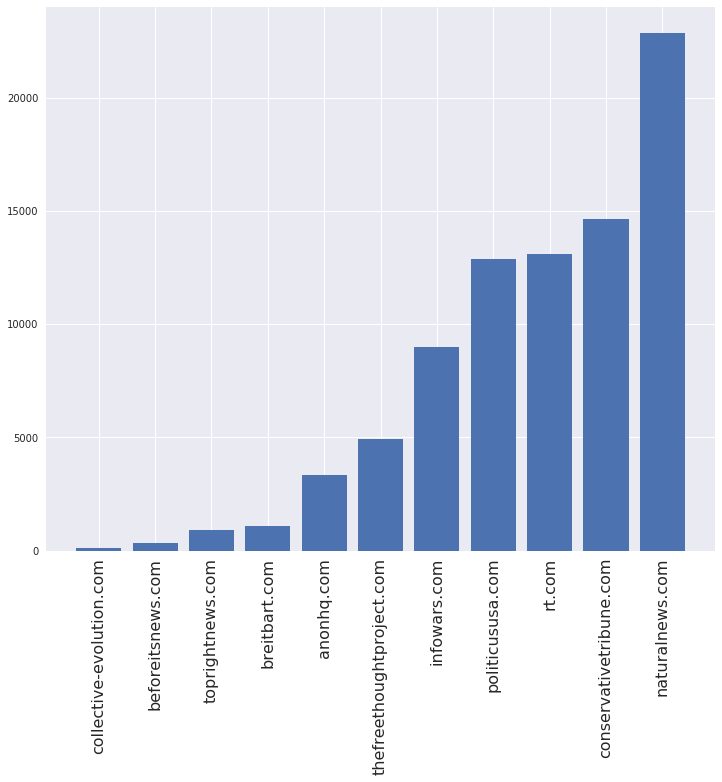

                           likes  shares  comments
site_url                                          
collective-evolution.com     138     138         3
beforeitsnews.com            336     336         0
toprightnews.com             912     912         0
breitbart.com               1082    1082         0
anonhq.com                  3348    3348         0
thefreethoughtproject.com   4939    4939        15
infowars.com                8977    8977         0
politicususa.com           12871   12871         0
rt.com                     13077   13077         0
conservativetribune.com    14659   14659       216
naturalnews.com            22853   22853         0


In [21]:
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()
print(shared_data_counts)

Index(['likes', 'shares', 'comments'], dtype='object')


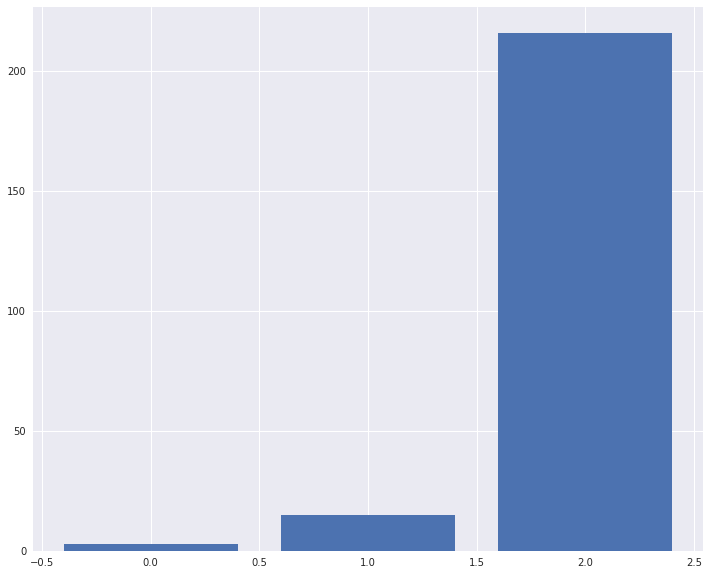

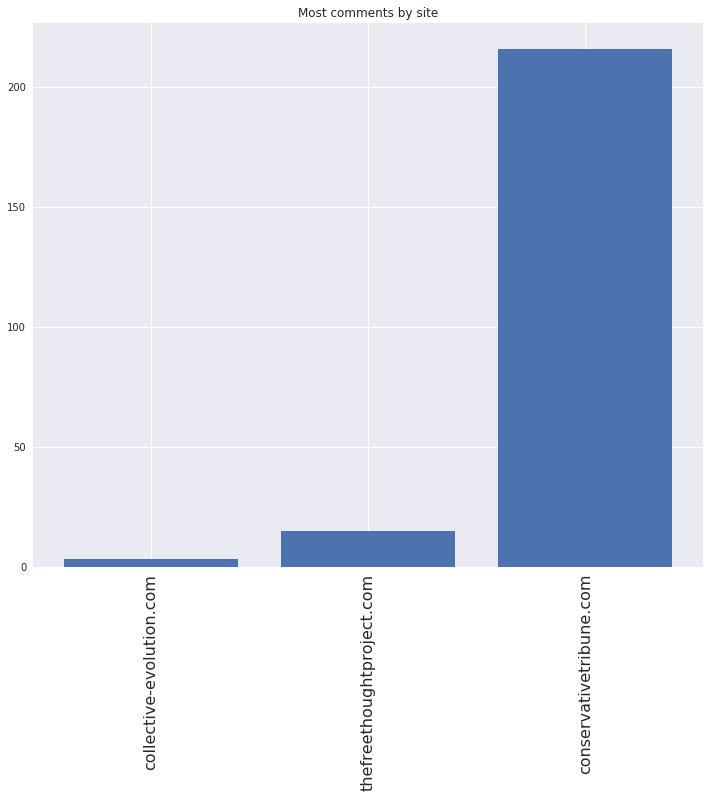

                           likes  shares  comments
site_url                                          
collective-evolution.com     138     138         3
thefreethoughtproject.com     95      95        15
conservativetribune.com    12531   12531       216


In [32]:
shared_data = data[['uuid', 'site_url', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.comments>0)]
shared_data_counts = shared_data.groupby('site_url').sum().sort_values(by=['comments'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.comments))], height = list(shared_data_counts.comments))
plt.xticks([x for x in range(len(shared_data_counts.comments))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.title("Most comments by site")
plt.show()
print(shared_data_counts)

In [33]:
data[data.comments==data.comments.max()]

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
1769,3ff8858a956f846c57d5d08f33553d8ed9b0e786,0,John Falkenberg,2016-10-27T01:44:38.370+03:00,Trump Haters Boycott Ivanka’s Clothing Line Be...,"“That is what ‘Trump’ means to me,” she said. ...",english,2016-10-27T01:44:38.370+03:00,conservativetribune.com,US,486.0,Trump Haters Boycott Ivanka’s Clothing Line Be...,0.0,http://static.conservativetribune.com/wp-conte...,0,1,16,30,16,bs


Overall I don't think the topics given in the type column in the dataset are very good. 
Next Im going to try extracting a new set of topics, as described over here: 
http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py in sci-kit learn. 

Index(['likes', 'shares', 'comments'], dtype='object')


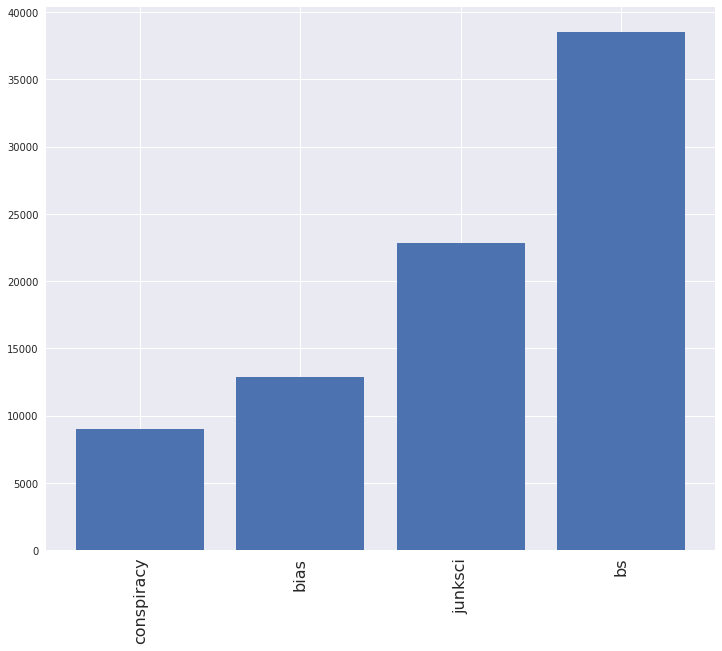

            likes  shares  comments
type                               
conspiracy   8977    8977         0
bias        12871   12871         0
junksci     22853   22853         0
bs          38491   38491       234


In [36]:
shared_data = data[['uuid', 'site_url', 'type', 'likes', 'shares', 'comments']]
shared_data = shared_data[(shared_data.likes>0) | (shared_data.shares>0) | (shared_data.comments>0)]
shared_data_counts = shared_data.groupby('type').sum().sort_values(by=['shares'])
print(shared_data_counts.columns)
# Weird that likes and share are exactly the same number
plt.figure(figsize=(12,10))
plt.bar(left=[x for x in range(len(shared_data_counts.likes))], height = list(shared_data_counts.shares))
plt.xticks([x for x in range(len(shared_data_counts.likes))], list(shared_data_counts.index), rotation="vertical", fontsize=16)
plt.show()
print(shared_data_counts)

In [18]:
get_topics(data.title)


Topics in NMF model (Frobenius norm):
Topic #0: hillary watch wikileaks vote leaked emails war weiner help michelle one voters audio rally comment would want breaking caught lead
Topic #1: trump donald supporter supporters says president media voting black vote watch star win anti voters campaign voter women people polls
Topic #2: new eastern outlook york report nuclear investigation economic life human elections year making comment europe south finds china operation movie
Topic #3: election day 2016 chart rigging audio violence america presidential americans one stolen ready rigged days fraud could schools 11 state
Topic #4: clinton campaign wikileaks bill foundation email emails comment leaked exposes podesta facebook state son audio black scandal report time control
Topic #5: us russia syria civilians isis mosul troops war putin world nato relations raqqa russian un iraq airstrikes killed military china
Topic #6: fbi investigation comey email director emails doj letter breaking reo

Ok, so now that is done the topics we get here are very different from the typology presented in the dataset. 
Indeed they are actual topics covered in the dataset. We see that the Clinton e-mail scandal features on its own 
in two different topics - one that covers a more legal stance and one that focuses more on the scandal itself.
The Syrian civil war is there, and so is the Dacota pipeline as well as a topic related to health. What does not
emerge here is whether these are bias or hate or conspiracy focused,
and perhaps each shares a substantial number of articles(TODO).
One of the topic has a lot of words that suggest some cleanup is in order. 

The major take-away is that fake-news seem to follow the scandals and important events of the 
day and seem to connect with them. An exception to this would be the natural news topics, which would follow 
its own niche that does not necessary reflect the big news. 

We can in fact do the same topic analysis on each of the subgroups of fake news we have. 

TODO: Get normal news from the same period and run the same excercise. 

In [14]:
get_topics(junksci.text)


Topics in NMF model (Frobenius norm):
Topic #0: food people health also organic like percent children time pain foods one brain natural many year study use get tea
Topic #1: clinton trump election hillary america criminal clintons vote democrats democracy political media news power democrat establishment steal corruption pretend government
Topic #2: water lemon alkaline juice hydrogen morning drink garlic body glass salt mixture day system skin drinking himalayan cold help add
Topic #3: cancer chemotherapy women breast ovarian johnson onions found researchers cells hospitals study rate treatment medical survival would medicine percent treatments
Topic #4: vitamin spinach carrots inflammation vitamins magnesium carrot sources fight minerals omega levels body juice raw antioxidant cooked rich beta tomatoes
Topic #5: pipeline dakota police land access government arrested climate public north private conspiracy reported law project amy theft said local years
Topic #6: gmo corn products no

In [15]:
get_topics(bs.text)


Topics in NMF model (Frobenius norm):
Topic #0: people one like would many time also even world us government years new get said make right year could may
Topic #1: clinton hillary campaign podesta email wikileaks obama emails bill president foundation election state john democratic clintons secretary presidential would media
Topic #2: trump donald election republican vote campaign president voting supporters voters candidate nominee presidential said party america voter women win american
Topic #3: russia russian syria us war military putin isis syrian mosul nuclear nato forces iraq china saudi western government civilians al
Topic #4: october 2016 https 27 twitter 28 pic co com 26 hillary 29 posted november share news right facebook get 10
Topic #5: david daily november day state 2016 data email latest leading mainstream posted governments violence available place markets financial well wednesday
Topic #6: fbi comey investigation emails clinton weiner director letter abedin server j

In [16]:
get_topics(bias.text)


Topics in NMF model (Frobenius norm):
Topic #0: trump donald election campaign republican women president clinton presidential nominee 2016 voters would hillary like said one going man october
Topic #1: facebook account comment via article disqus follow us times political officer wing popular police history elect go media wrong york
Topic #2: clinton emails hillary email fbi campaign republicans investigation podesta server scandal news obama new private voters polls early state said
Topic #3: found dead period israel woman century old ago said inside home police officers published year told york mins nypd three
Topic #4: comey fbi letter director election investigation james information emails republicans partisan hatch complaint democrats actions presidential political act department senate
Topic #5: percent points data poll 22 showed support economic lead market mins published 20 holding wednesday continued ago analysis losing florida
Topic #6: ballot county ballots absentee envelo

In [17]:
get_topics(hate.text)


Topics in NMF model (Frobenius norm):
Topic #0: fbi clinton hillary comey investigation department lynch doj emails campaign said justice director officials james attorney investigating election weiner media
Topic #1: women men woman husband allowed female prohibited trump iran mrs rape male public muslim hillary man clinton liberal speech must
Topic #2: israel resolution palestinian jerusalem unesco israeli jewish pa palestinians anti nations obama muslim council netanyahu us palestine security body russia
Topic #3: muslim muslims islam jihad splc religious islamic list christians tests cair muhammad isis allah hirsi terror brotherhood religion book ali
Topic #4: biden joe iran secretary iranian state senator bush fund make 200 check million terrorists obvious big would islamic want administration
Topic #5: states united un cuba resolution policy ambassador cuban obama embargo america communist us rhodes voted rights human power castro regime
Topic #6: obama clinton president left hi

###